In [20]:
import qutip as qt
import numpy as np
from quantum_logical.pulsesim import QuantumSystem, Pulse
from quantum_logical.pulsesim.mode import QubitMode, SNAILMode, CavityMode
from quantum_logical.pulsesim.build_hamiltonian import Build_hamiltonian
import matplotlib.pyplot as plt
from quantum_logical.channel import AmplitudeDamping, PhaseDamping
from quantum_logical.trotter import TrotterGroup
from quantum_logical.interaction import ConversionGainInteraction
from qutip import Options
from tqdm import tqdm
from progressbar import progressbar
from threading import Thread
from multiprocessing.pool import Pool, ThreadPool
from numpy.linalg import eig
from quantum_logical.creating_operators import Creating_operators
from quantum_logical.operators import selective_destroy

# opts = Options(nsteps=1e6, atol=1e-8, rtol=1e-6)
# p_bar = qt.ui.TextProgressBar()  # None
opts = {"nsteps": 1e6, "atol": 1e-8, "rtol": 1e-6, "progress_bar": "text"}

In [21]:
T1 = 80
T2 = 1
N = 2
dim = 3
trotter_dt = .02
psi0 = qt.tensor(qt.basis(dim, 2), qt.basis(dim, 0))
rho0 = psi0 * psi0.dag()
amp_damp_channel = AmplitudeDamping(T1, num_qubits=N, hilbert_space_dim=dim)
phase_damp_channel = PhaseDamping(T1, T2, num_qubits=N, hilbert_space_dim=dim)
trotter = TrotterGroup(
    continuous_operators=[amp_damp_channel, phase_damp_channel],
    trotter_dt=trotter_dt,
)


qt.Qobj(amp_damp_channel._create_single_qubit_operators(T1=1)[1])
rho0

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

In [22]:
fund_ops_list = []
H = Creating_operators(qubit_count=2, qubit_dim=3)
fund_ops_list.append(H.create_ops_unconventional_annhilation(from_level=0, to_level=1))  # this is not necessary with the new addition for the operator 
fund_ops_list.append(H.create_ops_unconventional_annhilation(from_level=1, to_level=2))

# # list of operators based on the fundamental single qubit operators 
# ops_list = []
# ops_list.append(qt.tensor(fund_ops_list[0], fund_ops_list[1].dag()))
# ops_list.append(qt.tensor(fund_ops_list[1], fund_ops_list[0].dag()))
# ops_list.append(qt.tensor(fund_ops_list[1].dag(), fund_ops_list[0]))
# ops_list.append(qt.tensor(fund_ops_list[0].dag(), fund_ops_list[1]))

# list of operators based on the full dimension operators
ops_list = []
ops_list.append(H.creating_ops_full_dim(qubit1_from=1, qubit1_to=0, qubit2_from=1, qubit2_to=2))
ops_list.append(H.creating_ops_full_dim(qubit1_from=2, qubit1_to=1, qubit2_from=0, qubit2_to=1))
ops_list.append(H.creating_ops_full_dim(qubit1_from=1, qubit1_to=2, qubit2_from=1, qubit2_to=0))
ops_list.append(H.creating_ops_full_dim(qubit1_from=0, qubit1_to=1, qubit2_from=2, qubit2_to=1))

ops_list1 = []
ops_list1.append(H.create_ops_unconventional_annhilation(from_level=1, to_level=0))
ops_list1.append(H.create_ops_unconventional_annhilation(from_level=2, to_level=1))

# this doesnt work yet but it is necessary for this to work
# ops_list2 = []
# ops_list1 = np.zeros((9,9), dtype=complex)
# for i in range(len(ops_list)):
#     for j in range(ops_list[i].shape[0]):
#         for k in range(ops_list[i].shape[0]):
#             ops_list1[j,k] = ops_list[i][j,k]
#     ops_list2.append(ops_list1)

# for i in range(len(ops_list2)):
#     ops_list2[i] = qt.Qobj(ops_list2[i])

# ops_list[0].shape[0]

states = []
xlist = []
ylist = []
proj = []

In [23]:
# create the projection operators and use them to break the results down 
for i in range(3):
    for j in range(3):
        proj.append(qt.tensor(qt.basis(dim, i), qt.basis(dim, j)) * qt.tensor(qt.basis(dim, i), qt.basis(dim, j)).dag())

qt.Qobj(proj[0].full())

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]

In [24]:
xnot = qt.tensor(H.not_gate(exchange_levels=[1,2]), qt.qeye(3))
H.not_gate(exchange_levels=[1,2])
# cnot = qt.tensor(qt.qeye(dim), H.not_gate(exchange_levels=[1,2]))
cnot = H.cnot_op(control=1, targets = [0,1])
cnot

Quantum object: dims=[[9], [9]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1.]]

In [25]:
# put in the target cnot 
# check that these operations give a cnot
H_new = ConversionGainInteraction(gg=np.pi / 4, gc= np.pi / 4, transmon_levels=3)
U_cnot_no_time = H_new.construct_U(1.0)
# H_mine = (np.pi / 4) * qt.tensor(ops_list1[0], ops_list1[0].dag()) + (np.pi / 4) * qt.tensor(ops_list1[0], ops_list1[0]) + (np.pi / 4) * qt.tensor(ops_list1[0], ops_list1[0].dag()).dag() + (np.pi / 4) * qt.tensor(ops_list1[0], ops_list1[0]).dag()
# U_mine = H.propagator(H=H_mine, T=1)
# U_mine
U_cnot_no_time

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.70710678+0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        -0.70710678j 0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.70710678+0.j         0.        +0.j
  0.        -0.70710678j 0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        +0.j         1.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.        -0.70710678j 0.        +0.j
  0.70710678+0.j         0.        +0.j         0.        +0.j
  0.        +0.j         0.        +0.j         0.        +0.j        ]
 [0.        -0.70710678j 0.        +0.j         0.        +0.j
  0.        +0.j         0.70710678+0.j  

In [26]:
# states = []
psi_after_xgate = trotter.apply(state=rho0, duration=50, discrete_unitary=xnot)
# for i in range(len(proj)):
#     val = proj[i].full()
#     val_dag = val.dag()
#     xlist.append(val * psi_after_xgate.full() * val_dag)
# psi_after_xgate
# for i in psi_after_xgate:
#     for j in range(len(proj)):
#         val = proj[i].full()
#         val_dag = val.dag()
psi_after_xgate[-1]

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1.44997847e-01+2.26841688e-19j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000

In [27]:
# for i in tqdm(range(351)):
psi_after_cnot = trotter.apply(state=psi_after_xgate[-1], duration=250, discrete_unitary=cnot)
# states.append(psi_after_cnot)
psi_after_cnot[-1]

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 7.06879356e-01+7.32039773e-20j -1.36096085e-13+1.33560189e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-1.36096295e-13-1.33560189e-01j  8.52799926e-02-3.88671577e-20j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]


In [28]:
# for i in tqdm(range(51)):
psi_after_last_xnot = trotter.apply(state=psi_after_cnot[-1], duration=50, discrete_unitary=xnot)
    # states.append(psi_after_last_xnot)
psi_after_last_xnot[-1]

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 7.49845853e-01+1.36416586e-17j -3.68026713e-04+1.21674141e-01j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-3.68026713e-04-1.21674141e-01j  7.38534619e-02-7.43315114e-20j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]


In [29]:
# getting the data to plot 
states = []
states.extend(psi_after_xgate)
states.extend(psi_after_cnot)
states.extend(psi_after_last_xnot)
values = []
# len(states)
for i in states:
    for j in range(9):
        values.append(i[j,j])
len(values)

gg = []
ge = []
gf = []
eg = []
ee = []
ef = []
fg = []
fe = []
ff = []

for i in range(len(states)):
    gg.append(values[(i * 9)])
    ge.append(values[(i * 9) + 1])
    gf.append(values[(i * 9) + 2]) 
    eg.append(values[(i * 9) + 3]) 
    ee.append(values[(i * 9) + 4])
    ef.append(values[(i * 9) + 5])
    fg.append(values[(i * 9) + 6]) 
    fe.append(values[(i * 9) + 7])
    ff.append(values[(i * 9) + 8])

time_plot = np.linspace(0, 350, 17500)

C:\Users\girgi\AppData\Local\Temp\ipykernel_19364\298530530.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Text(0, 0.5, 'state occupancy')

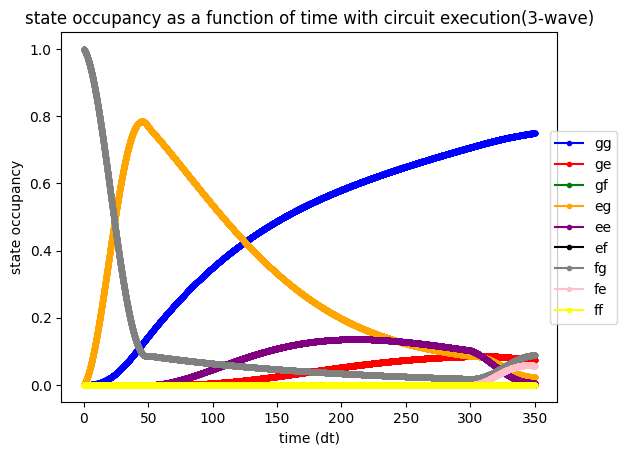

In [30]:
# creating the plot 
fig, ax = plt.subplots()
ax.plot(time_plot, gg, 'blue', marker = '.', label = 'gg')
ax.plot(time_plot, ge, 'red', marker = '.', label = 'ge' )
ax.plot(time_plot, gf, 'green', marker = '.', label = 'gf')
ax.plot(time_plot, eg, 'orange', marker = '.', label = 'eg')
ax.plot(time_plot, ee, 'purple', marker = '.', label = 'ee')
ax.plot(time_plot, ef, 'black', marker = '.', label = 'ef')
ax.plot(time_plot, fg, 'gray', marker = '.', label = 'fg')
ax.plot(time_plot, fe, 'pink', marker = '.', label = 'fe')
ax.plot(time_plot, ff, 'yellow', marker = '.', label = 'ff')
fig.legend(loc = "center right")
fig.show()
ax.set_title('state occupancy as a function of time with circuit execution(3-wave)')
ax.set_xlabel('time (dt)')
ax.set_ylabel("state occupancy")

In [31]:
state_after_1_xnot = xnot * rho0 * xnot.dag()
state_after_cnot = U_cnot_no_time * state_after_1_xnot * U_cnot_no_time.dag()
final_state = xnot * state_after_cnot * xnot.dag()
final_state

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j ]
 [0. +0.j  0.5+0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. -0.5j 0. +0.j
  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j ]
 [0. +0.j  0. +0.5j 0. +0.j  0. +0.j  0. +0.j  0. +0.j  0.5+0.j  0. +0.j
  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j  0. +0.j
  0. +0.j ]]

In [32]:
qt.fidelity(final_state, psi_after_last_xnot[-1])

0.28495534530859823

In [33]:
# states = []
psi_after_5xgate = trotter.apply(state=rho0, duration=50, discrete_unitary=xnot)
# for i in range(len(proj)):
#     val = proj[i].full()
#     val_dag = val.dag()
#     xlist.append(val * psi_after_xgate.full() * val_dag)
# psi_after_xgate
# for i in psi_after_xgate:
#     for j in range(len(proj)):
#         val = proj[i].full()
#         val_dag = val.dag()
psi_after_5xgate[-1]

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1.44997847e-01+2.26841688e-19j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
  0.00000000e+00+0.00000000e+00j]
 [0.00000000e+00+0.00000000

In [34]:
# start the 5-wave benchmark 
psi_after_5cnot = trotter.apply(state=psi_after_5xgate[-1], duration=2500, discrete_unitary=cnot)
psi_after_5cnot[-1]

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 9.99999530e-01+1.25187300e-24j -3.64838065e-15+7.45484038e-05j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-3.64838070e-15-7.45484038e-05j  1.05728606e-07-1.12739938e-25j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]


In [35]:
psi_after_last_5xnot = trotter.apply(state=psi_after_5cnot[-1], duration=50, discrete_unitary=xnot)
psi_after_last_5xnot[-1]

Quantum object: dims=[[3, 3], [3, 3]], shape=(9, 9), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 9.99999613e-01+4.74597795e-23j -6.50719009e-11+6.37727981e-05j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [-6.50719009e-11-6.37727981e-05j  7.86458956e-08-8.67261979e-26j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j]


In [36]:
# getting the data to plot 
states1 = []
states1.extend(psi_after_5xgate)
states1.extend(psi_after_5cnot)
states1.extend(psi_after_last_5xnot)
values1 = []
# len(states)
for i in states1:
    for j in range(9):
        values1.append(i[j,j])
len(values1)

gg1 = []
ge1 = []
gf1 = []
eg1 = []
ee1 = []
ef1 = []
fg1 = []
fe1 = []
ff1 = []

for i in range(len(states1)):
    gg1.append(values1[(i * 9)])
    ge1.append(values1[(i * 9) + 1])
    gf1.append(values1[(i * 9) + 2]) 
    eg1.append(values1[(i * 9) + 3]) 
    ee1.append(values1[(i * 9) + 4])
    ef1.append(values1[(i * 9) + 5])
    fg1.append(values1[(i * 9) + 6]) 
    fe1.append(values1[(i * 9) + 7])
    ff1.append(values1[(i * 9) + 8])

time_plot2 = np.linspace(0, 2600, 130000)

C:\Users\girgi\AppData\Local\Temp\ipykernel_19364\959055465.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Text(0, 0.5, 'state occupancy')

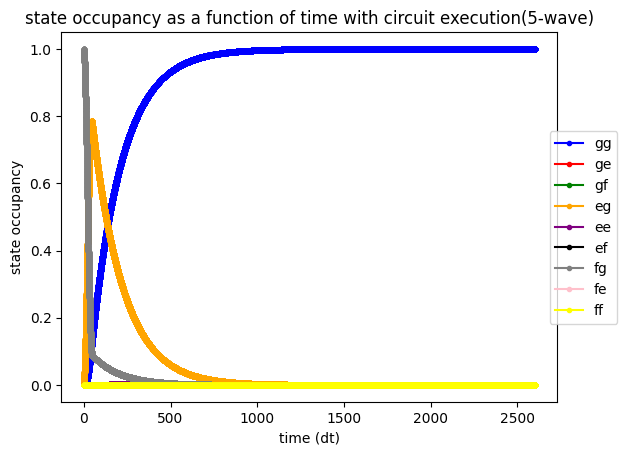

In [37]:
# use the data above and build the plot
fig, ax = plt.subplots()
ax.plot(time_plot2, gg1, 'blue', marker = '.', label = 'gg')
ax.plot(time_plot2, ge1, 'red', marker = '.', label = 'ge' )
ax.plot(time_plot2, gf1, 'green', marker = '.', label = 'gf')
ax.plot(time_plot2, eg1, 'orange', marker = '.', label = 'eg')
ax.plot(time_plot2, ee1, 'purple', marker = '.', label = 'ee')
ax.plot(time_plot2, ef1, 'black', marker = '.', label = 'ef')
ax.plot(time_plot2, fg1, 'gray', marker = '.', label = 'fg')
ax.plot(time_plot2, fe1, 'pink', marker = '.', label = 'fe')
ax.plot(time_plot2, ff1, 'yellow', marker = '.', label = 'ff')
fig.legend(loc = "center right")
fig.show()
ax.set_title('state occupancy as a function of time with circuit execution(5-wave)')
ax.set_xlabel('time (dt)')
ax.set_ylabel("state occupancy")

In [38]:
qt.fidelity(final_state, psi_after_last_5xnot[-1])

0.00041180773473479133